In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

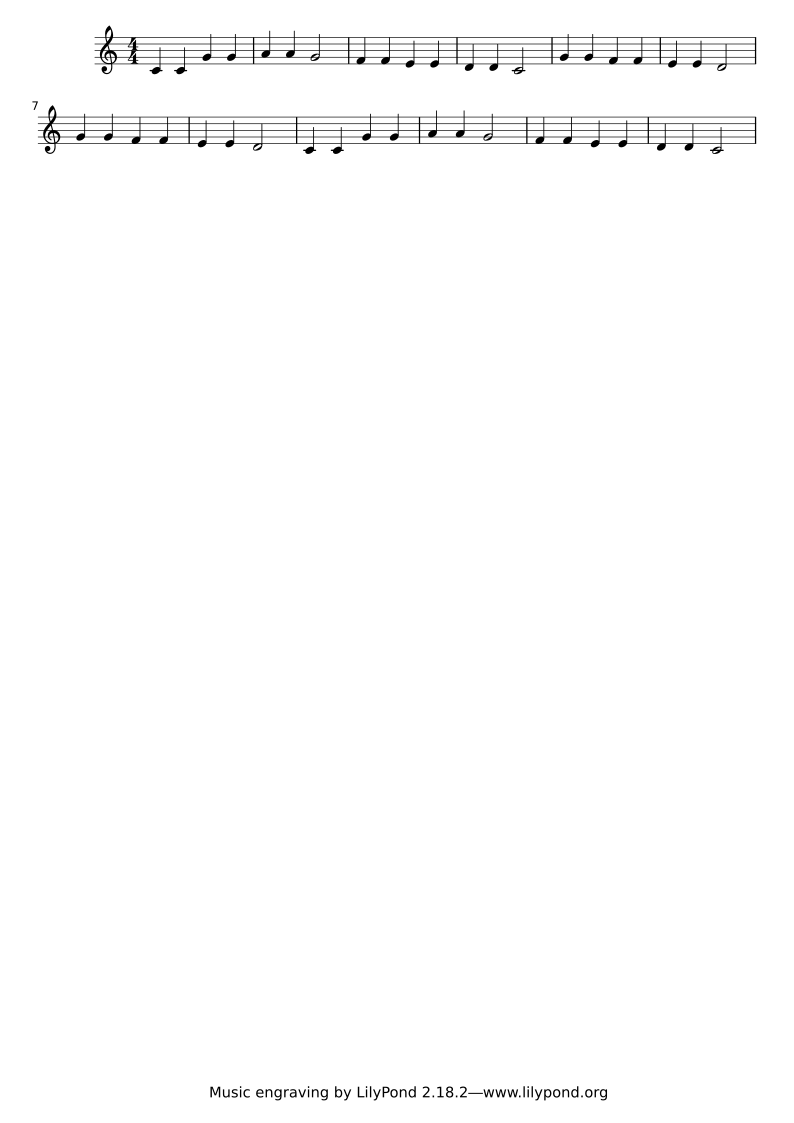

In [25]:
image = Image.open('../data/twinkle.png')
image

In [22]:
w,h   = 64,64
def see(x0,y0):
    x1,y1 = x0+w,y0+h
    return image.crop((x0,y0,x1,y1))

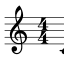

In [23]:
see(90,20)

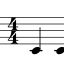

In [24]:
see(120,20)